### VQA :  <br>
- 시각적 질의응답 (Visual Question Answering)<Br> 시각적인 이미지와 그 이미지에 대한 질문을 입력했을 때, <br> 질문에 적절한 답을 제공하는 인공지능 기술


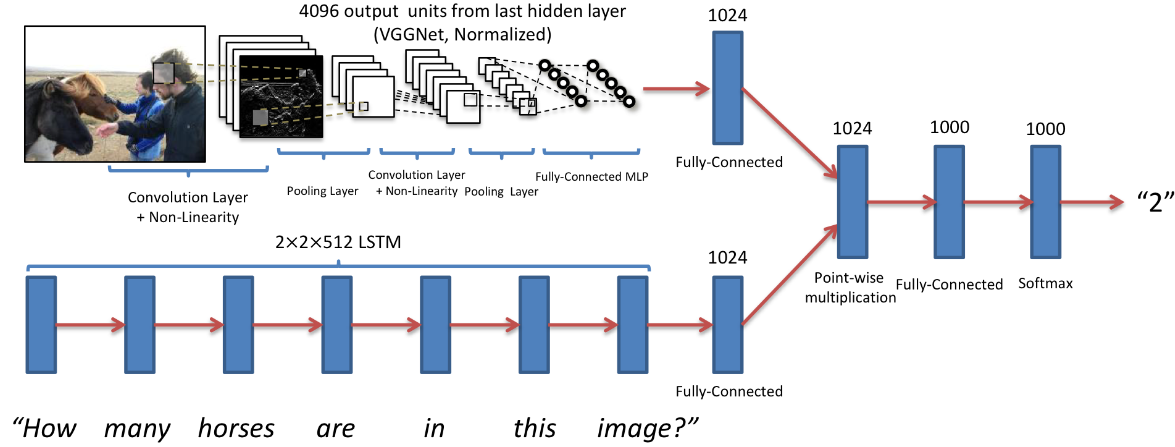

https://velog.io/@stophyunn/VQA-Visual-Question-Answering

**VQA 예제** <br>
CNN :  **이미지**에서 특징 추출 - 공간 정보 추출<br>
RNN/LSTM : **텍스트**(질문) 처리(인코딩) - 순차적 특성 처리

1. 합성 이미지 및 데이터 생성

In [88]:
# PIL 라이브러리를 사용하여 이미지 생성
# 질문-답변 set 처리.

from PIL import Image
   # Python Imaging Library(PIL)은 파이썬 인터프리터에 다양한 이미지 파일 형식을 지원하고
   # 강력한 이미지 처리와 그래픽 기능을 제공하는 자유-오픈 소스 소프트웨어 라이브러리이다. -  wiki
import numpy as np
import random

def generate_data(num_samples):
    colors = {
        'red': (255, 0, 0),
        'green': (0, 255, 0),
        'blue': (0, 0, 255),
        'yellow': (255, 255, 0),
        'magenta': (255, 0, 255),
        'cyan': (0, 255, 255)
    }
    questions = []
    answers = []
    images = []

    # 데이타 생성
    for _ in range(num_samples):
        color_name, rgb = random.choice(list(colors.items()))
        # 랜덤 선택된 컬로의 이미지 생성
        image = Image.new("RGB", (224, 224), color=rgb)
        images.append(image)
        # 질문-답 생성
        question = f"What is the color of the image?"
        answer = color_name
        questions.append(question)
        answers.append(answer)

    return images, questions, answers

# synthetic data(합성 데이터)
num_samples = 100  # 생성할 샘플 데이터 수
images, questions, answers = generate_data(num_samples)


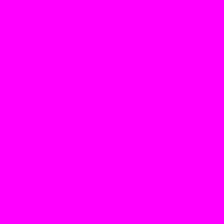

In [89]:
images[95]

In [90]:
print(questions[95])
print(answers[95])

What is the color of the image?
magenta


2.모델 입력을 위한 데이터 전처리

In [91]:
# 이미지 데이터를 모델 입력에 적합한 형식으로 변환
# 텍스트 토큰화
# 답변 인코딩

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 이미지를 numpy arrays 로 변환
# 모델 입력에 맞추어 조정
image_data = np.array([np.array(img) for img in images])

# 질문 텍스트 토큰화
# Tokenizing : 텍스트를 일정한 크기나 형태의 단위로 분리
tokenizer = Tokenizer() # Tokenizer 클래스를 통해 인스턴스 생성 -> 텍스트 토큰화, 각 토큰을 숫자 인덱스에 매핑
tokenizer.fit_on_texts(questions) # fit_on_texts : 데이터 내의 모든 단어 분석 -> 단어 사전 구축 -> 각 단어를 고유한 정수 인덱스로 매핑
question_sequences = tokenizer.texts_to_sequences(questions) # 질문을 구성하는 단어들의 인덱스 리스트로 변환
question_data = pad_sequences(question_sequences, maxlen=10) # 시퀀스의 최대 길이를 10으로 설정, 길이를 맞춤
########### 텍스트를 벡터화 -> 각 토큰은 벡터의 한 차원을 대표


# 답변 인코딩
label_encoder = LabelEncoder()
answer_labels = label_encoder.fit_transform(answers)
answer_data = to_categorical(answer_labels)

print("Images shape:", image_data.shape)
print("Questions shape:", question_data.shape)
print("Answers shape:", answer_data.shape)


Images shape: (100, 224, 224, 3)
Questions shape: (100, 10)
Answers shape: (100, 6)


Images shape: (100, 224, 224, 3) : 224*224 컬러이미지 총 100개 <br>
Questions shape: (100, 10) 100  : 총 질문 갯수, 10:각 질문의 최대 길이 <br>
Answers shape: (100, 6) :  6 답변의 범주 수 <br>

In [92]:
questions

['What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the image?',
 'What is the color of the i

In [93]:
question_data[0]

array([0, 0, 0, 2, 3, 1, 4, 5, 1, 6], dtype=int32)

 "What is the color of the image?" <br>
1: the <br>
2: is <br>
3: What <br>
4: color <br>
5: of <br>
6: image? <br>

3.모델 설계, 학습

In [94]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Embedding, LSTM, concatenate

# 모델 정의
def build_model(vocab_size, num_answers):
    # Image 처리 - CNN
    image_input = Input(shape=(224, 224, 3))
    x = Conv2D(16, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    image_model = Dense(128, activation='relu')(x)

    # Text 처리 - LSTM
    text_input = Input(shape=(10,))
    y = Embedding(input_dim=vocab_size, output_dim=64, input_length=10)(text_input)
    y = LSTM(64)(y)
    text_model = Dense(128, activation='relu')(y)

    # 모델 결합
    combined = concatenate([image_model, text_model])
    output = Dense(num_answers, activation='softmax')(combined)
    model = Model(inputs=[image_input, text_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model



In [95]:
#  모델 build
vocab_size = len(tokenizer.word_index) + 1
num_answers = answer_data.shape[1]
model = build_model(vocab_size, num_answers)

/home/tommy/miniconda3/envs/py311/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [96]:
# 모델 학습
model.fit([image_data, question_data], answer_data, epochs=10, batch_size=32)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4033 - loss: 2809.8208
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9400 - loss: 130.1634
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8954 - loss: 70.8933
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9020 - loss: 86.6454
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9696 - loss: 1.5386   
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0000e+00


모델 성능 테스트를 위한 데이터 생성

In [97]:
# test data 생성
num_test_samples = 20  # test 데이터 수
test_images, test_questions, test_answers = generate_data(num_test_samples)

# test images를 numpy arrays 로 변환.. model 입력을 위해
test_image_data = np.array([np.array(img) for img in test_images])

# Process test questions
test_question_sequences = tokenizer.texts_to_sequences(test_questions)
test_question_data = pad_sequences(test_question_sequences, maxlen=10)

# Encode test answers
test_answer_labels = label_encoder.transform(test_answers)
test_answer_data = to_categorical(test_answer_labels)


모델 평가

In [98]:
# 모델 평가
loss, accuracy = model.evaluate([test_image_data, test_question_data], test_answer_data)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Loss: 0.0000
Test Accuracy: 1.0000


예측하기

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


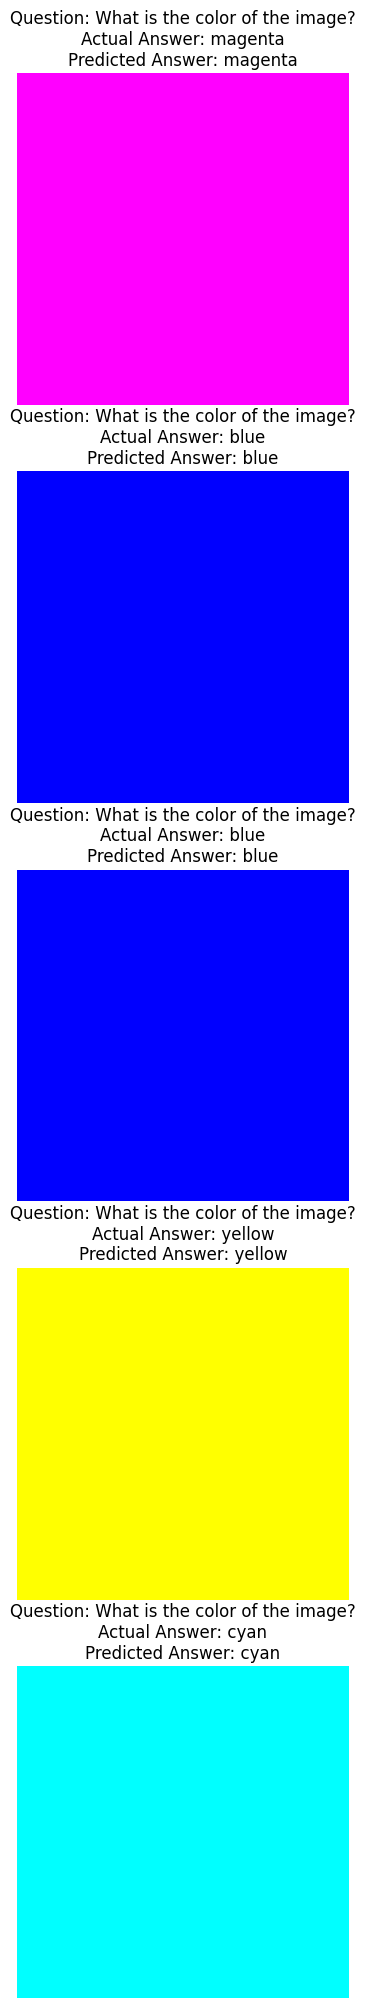

In [99]:
import matplotlib.pyplot as plt

# 예측 수행
predictions = model.predict([test_image_data, test_question_data])
predicted_answers = np.argmax(predictions, axis=1)

# 원 답변으로 변환
predicted_answer_labels = label_encoder.inverse_transform(predicted_answers)

# 테스트 결과 보기
num_display = 5  # 5개 결과만 ....
fig, axes = plt.subplots(num_display, 1, figsize=(5, 5 * num_display))

for i in range(num_display):
    ax = axes[i]
    ax.imshow(test_images[i])  # 이미지 보기
    ax.axis('off')
    ax.set_title(f"Question: {test_questions[i]}\n"
                 f"Actual Answer: {test_answers[i]}\n"
                 f"Predicted Answer: {predicted_answer_labels[i]}")

plt.show()


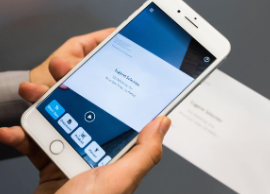